In [ ]:
import glob
import pandas as pd
import calendar
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_files():
    filelist = []

    for file in (glob.glob("*.txt")):
        filelist.append(file)
        list_dfs = [pd.read_csv(file) for file in filelist]

    df = pd.concat(list_dfs, ignore_index=True)
    df.columns = df.columns.str.strip()
    return df

df = read_files()


In [3]:
def clean_df(df):

    #change time and dates
    df['WEEKDAY'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y').dt.weekday_name
    df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME, format='%m/%d/%Y %H:%M:%S')
    df['MONTH'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y').dt.month
    df['MONTH'] = df['MONTH'].apply(lambda x: calendar.month_abbr[x])

    #combine station key and drop path and srt
    df.drop(df[df.DIVISION == 'PTH'].index, inplace=True)
    df.drop(df[df.DIVISION == 'SRT'].index, inplace=True)
    df['STATION_KEY'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['STATION']
    df['STATION_LINE'] = df['STATION'] + '-' + df['LINENAME']

    #sort frame
    df.sort_values(['STATION_KEY', 'SCP', 'DATETIME'], inplace=True)

    #get diffs and reduce dataset
    df['ENTRY_DIFFS'] = df.groupby(['STATION_KEY', 'SCP']).ENTRIES.apply(lambda g: g.diff())
    df['EXIT_DIFFS'] = df.groupby(['STATION_KEY', 'SCP']).EXITS.apply(lambda g: g.diff())
    df.fillna(0, inplace=True)
    
    df.loc[df['ENTRY_DIFFS'] < 0, 'ENTRY_DIFFS'] = np.nan
    df.loc[df['ENTRY_DIFFS'] > 25000, 'ENTRY_DIFFS'] = np.nan
    df.loc[df['EXIT_DIFFS'] < 0, 'EXIT_DIFFS'] = np.nan
    df.loc[df['EXIT_DIFFS'] > 25000, 'EXIT_DIFFS'] = np.nan

    #add traffic
    df['TRAFFIC'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']

    return df


df = clean_df(df)

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,WEEKDAY,DATETIME,MONTH,STATION_KEY,STATION_LINE,ENTRY_DIFFS,EXIT_DIFFS,TRAFFIC
791615,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901,Saturday,2018-06-23 00:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,0.0,0.0,0.0
791616,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909,Saturday,2018-06-23 04:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,23.0,8.0,31.0
791617,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938,Saturday,2018-06-23 08:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,16.0,29.0,45.0
791618,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006,Saturday,2018-06-23 12:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,116.0,68.0,184.0
791619,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066,Saturday,2018-06-23 16:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,229.0,60.0,289.0


In [23]:
#top 25 traffic 

traffic_df = (df.groupby('STATION_LINE')['TRAFFIC','ENTRY_DIFFS','EXIT_DIFFS'].sum())
top_10_stations = traffic_df.sort_values(by='TRAFFIC', ascending=False).head(10)
top_10_stations

,TRAFFIC,ENTRY_DIFFS,EXIT_DIFFS
STATION_LINE,,,
GRD CNTRL-42 ST-4567S,22711022.0,11924871.0,10786198.0
34 ST-HERALD SQ-BDFMNQRW,17790710.0,9193215.0,9148058.0
34 ST-PENN STA-ACE,12729438.0,6699025.0,6030413.0
42 ST-PORT AUTH-ACENQRS1237W,11679637.0,6749724.0,5299559.0
14 ST-UNION SQ-LNQR456W,11316818.0,6060660.0,5256158.0
TIMES SQ-42 ST-1237ACENQRSW,10866632.0,5436368.0,5542468.0
FULTON ST-2345ACJZ,10263484.0,5300979.0,4962505.0
47-50 STS ROCK-BDFM,8923655.0,4377535.0,4546120.0
FLUSHING-MAIN-7,8813237.0,4819795.0,3993442.0


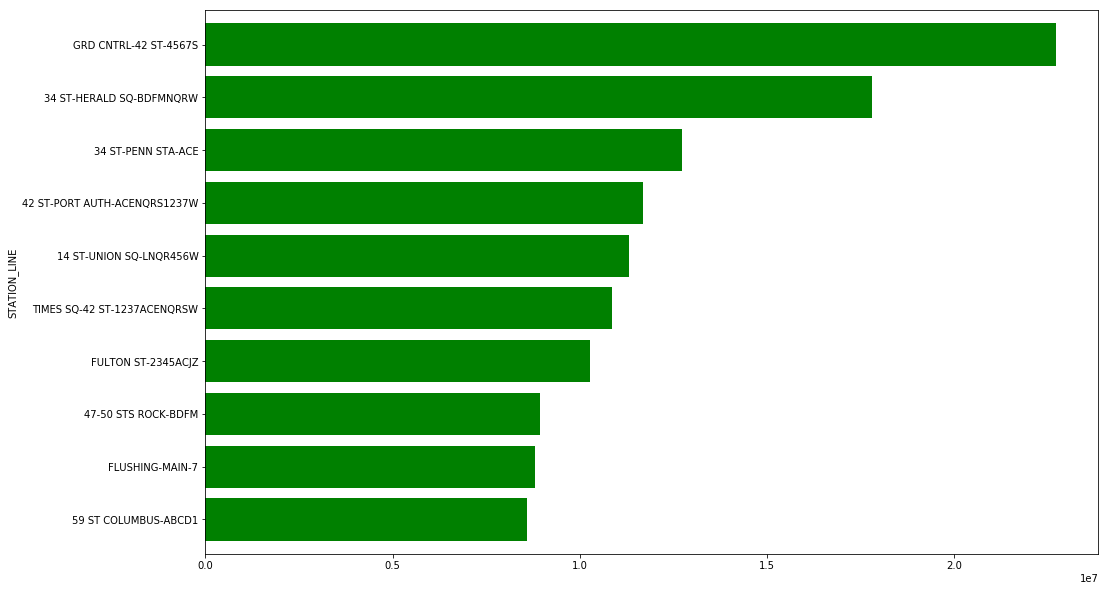

In [24]:
#top 10 stations by traffic
(top_10_stations['TRAFFIC'].sort_values()
 .plot(kind='barh',
       color = 'green', 
       linewidth=10,
       width=0.8,
       align='center',
       figsize =(16,10)
      )
) 

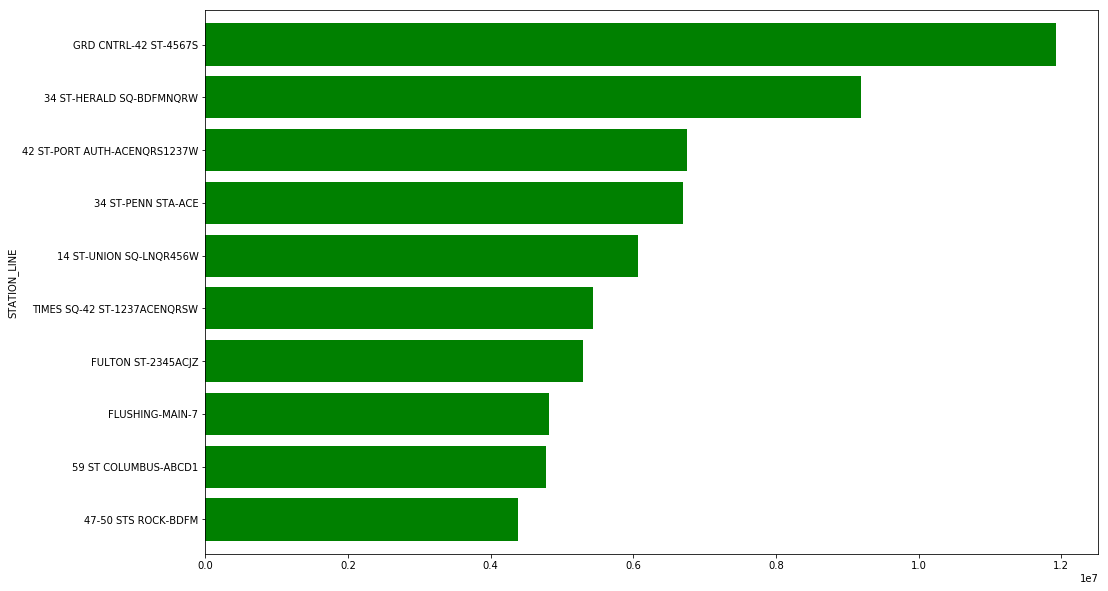

In [25]:
#top 10 by entries
(top_10_stations['ENTRY_DIFFS'].sort_values()
 .plot(kind='barh',
       color = 'green', 
       linewidth=10,
       width=0.8,
       align='center',
       figsize =(16,10)
      )
) 

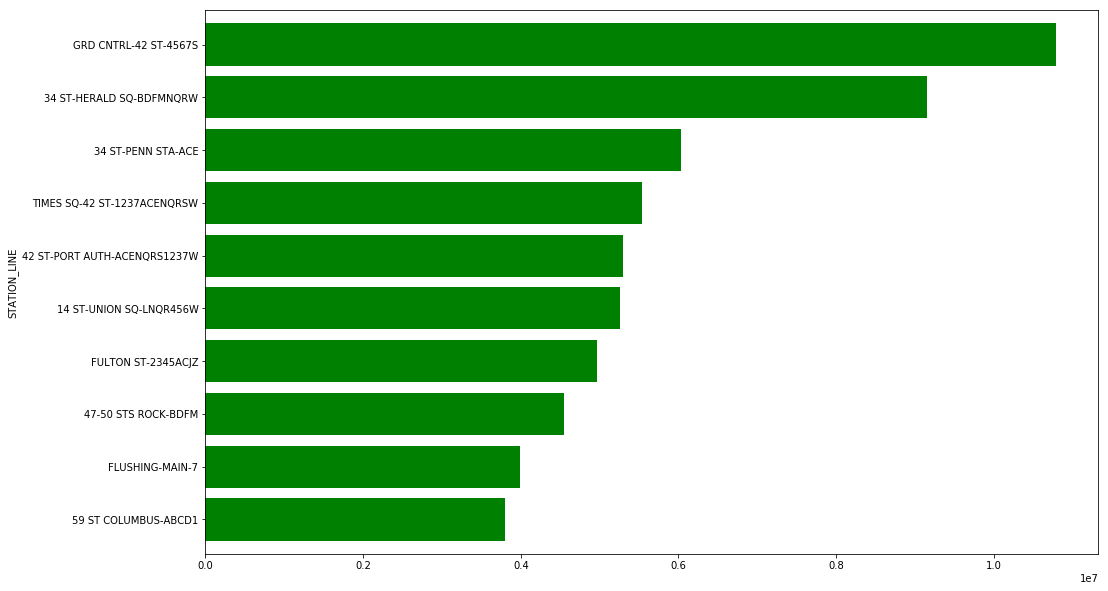

In [26]:
#top 10 by exits
(top_10_stations['EXIT_DIFFS'].sort_values()
 .plot(kind='barh',
       color = 'green', 
       linewidth=10,
       width=0.8,
       align='center',
       figsize =(16,10)
      )
)

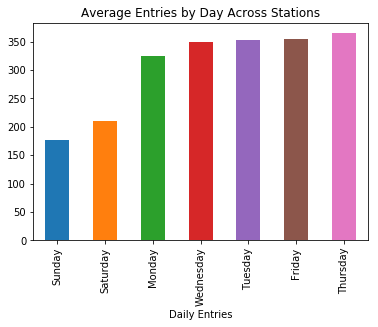

In [38]:
ax = df.groupby('WEEKDAY').TRAFFIC.mean().sort_values().plot(kind='bar',title="Average Entries by Day Across Stations");
ax.set_xlabel("Daily Entries");

In [62]:
df['DAYWEEK'] = df['DATETIME'].apply(lambda x: x.weekday())
third = df[['STATION','DAYWEEK','ENTRY_DIFFS', 'EXIT_DIFFS', 'TRAFFIC']]
fourth = third.reset_index().groupby(['STATION','DAYWEEK']).sum().reset_index()
fifth = fourth.groupby(['STATION']).sum()[['ENTRY_DIFFS', 'EXIT_DIFFS', 'TRAFFIC']]
sixth = fifth.sort_values(by = 'TRAFFIC', ascending = False).head(10).reset_index()

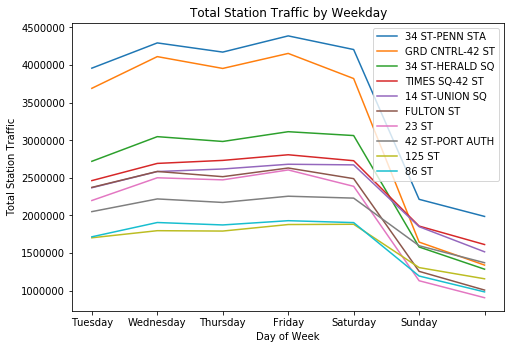

In [63]:
fig = plt.figure()

x = range(0,7)
axes = fig.add_axes([0, 0, 1, 1])

for station in list(sixth['STATION']):
    y = fourth[fourth['STATION'] == station]['TRAFFIC']
    axes.plot(x, y, label = station)

axes.set_xlabel('Day of Week') # Notice the use of set_ to begin methods
axes.set_ylabel('Total Station Traffic')
axes.set_title('Total Station Traffic by Weekday')
axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes.legend();

In [66]:
top_stations = list(sixth['STATION'])
seventh = df.reset_index()
eighth = seventh[seventh['DAYWEEK'] < 6].copy()
eighth['TIME'] = eighth['DATETIME'].apply(lambda x: x.time())
ninth = eighth.groupby(['STATION','TIME']).sum()[['ENTRY_DIFFS','EXIT_DIFFS','TRAFFIC']].loc[top_stations]
tenth = ninth.groupby(level = [0]).cumsum().reset_index()
time_list = [datetime.time(0,0), datetime.time(4,0), datetime.time(8,0), datetime.time(12,0), datetime.time(16,0),datetime.time(20,0)]
eleventh = tenth[tenth['TIME'].isin(time_list)].copy()
eleventh['ENTRIES'] = eleventh['ENTRY_DIFFS'].diff()
eleventh['EXITS'] = eleventh['EXIT_DIFFS'].diff()
eleventh['PERIOD TOTAL'] = eleventh['TRAFFIC'].diff()
twelfth = eleventh[eleventh['TIME'] != datetime.time(0,0)]


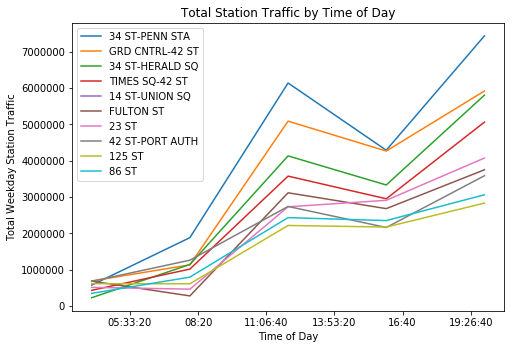

In [67]:
fig = plt.figure()

axes = fig.add_axes([0, 0, 1, 1])

for station in top_stations:
    x = twelfth[twelfth['STATION'] == station]['TIME']
    y = twelfth[twelfth['STATION'] == station]['PERIOD TOTAL']
    axes.plot(x, y, label = station)

axes.set_xlabel('Time of Day') 
axes.set_ylabel('Total Weekday Station Traffic')
axes.set_title('Total Station Traffic by Time of Day')
axes.legend();

In [72]:
grp3=df.groupby(['STATION_LINE','DATE'])['TRAFFIC'].sum()
grp4=grp3.reset_index()
top=grp4.groupby(['STATION_LINE'])['TRAFFIC'].median()
top1=top.sort_values()
top2=top1.tail(20)

Text(0.5,1,' Top 20 Stations by Median Daily Traffic  ')

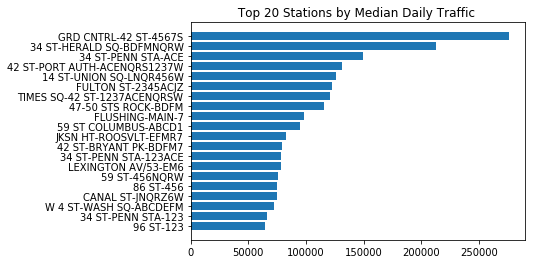

In [73]:
plt.figsize=[20,8]

plt.barh( top2.index,top2.values)
plt.title(' Top 20 Stations by Median Daily Traffic  ')

In [74]:
def weekend(x):
    if x <= 4:
        return 1
    else:
        return 0

In [75]:
df['WEEKDAY']=df['DAYWEEK'].apply(weekend)

In [76]:
df3 = df
df3.reset_index(inplace=True,drop=True)
df3.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,WEEKDAY,DATETIME,MONTH,STATION_KEY,STATION_LINE,ENTRY_DIFFS,EXIT_DIFFS,TRAFFIC,DAYWEEK
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901,0,2018-06-23 00:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,0.0,0.0,0.0,5
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909,0,2018-06-23 04:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,23.0,8.0,31.0,5
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938,0,2018-06-23 08:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,16.0,29.0,45.0,5
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006,0,2018-06-23 12:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,116.0,68.0,184.0,5
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066,0,2018-06-23 16:00:00,Jun,A002 R051 59 ST,59 ST-NQR456W,229.0,60.0,289.0,5


In [77]:
df_day=df3.groupby(['STATION_LINE','DATE','WEEKDAY'])['TRAFFIC'].sum()
df_day.head()
df_h=df_day.reset_index()

In [78]:
df_w=df_h.groupby(['STATION_LINE','WEEKDAY'])['TRAFFIC'].median().unstack()

In [79]:
df_w.head()

WEEKDAY,0,1
STATION_LINE,,
1 AV-L,30301.5,41574.0
103 ST-1,12127.5,17745.5
103 ST-6,11845.5,23384.0
103 ST-BC,4335.5,10031.5
103 ST-CORONA-7,20821.5,33057.5


In [80]:
df_w['WEEK_RATIO']=(df_w[1])/(df_w[0])

In [81]:
final_df=df_w.dropna()

In [82]:
final_df.sort_values(by='WEEK_RATIO')

WEEKDAY,0,1,WEEK_RATIO
STATION_LINE,,,
ORCHARD BEACH-6,123.5,2.0,0.016194
RIT-MANHATTAN-R,4435.5,3490.0,0.786834
AQUEDUCT RACETR-A,2690.5,2243.0,0.833674
161/YANKEE STAD-4BD,15849.5,13259.5,0.836588
RIT-ROOSEVELT-R,4039.0,3402.0,0.842288
METS-WILLETS PT-7,14108.5,12375.0,0.877131
CRESCENT ST-JZ,9627.5,9060.0,0.941054
QUEENSBORO PLZ-7NQW,19890.5,19301.0,0.970363
W 8 ST-AQUARIUM-FQ,6275.0,6195.5,0.987331
